In [3]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import argparse

# *************************************************



time = [65]
models = ["GAM"]
taxas = ["Mammals"]



years= ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050','2052', '2056', '2080', '2100', '2150', '2200', '2250']
year_indices = {35: 9, 65: 12, 85: 13}
selected_year = years[year_indices[time[0]]]
if time[0] == 35 or time[0] == 65:
    GCMs = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['GFDL.ESM2M', 'IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26","rcp60"]

elif time[0] == 85:
    GCMs = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
    bioscen_GCMs = ['IPSL.CM5A-LR', 'HadGEM2.ES', 'MIROC5']
    scenarios = ["rcp26"]

    
#combinations = list(itertools.product(models, model_names))

for model in models:
    for taxa in taxas:
        print("Taxa", taxa)
        print("Model", model)
        print("Time", time[0])
        for GCM, bioscen_GCM in zip(GCMs, bioscen_GCMs):
            print("GCM", GCM, "bioscen_GCM", bioscen_GCM)
            for scenario in scenarios:
                print("Scenario", scenario)
                if scenario == "rcp26":
                    ssprcp_short = "ssp126"
                elif scenario == "rcp60":
                    ssprcp_short = "ssp460"
                print("ssprcp_short", ssprcp_short)
                    # Your code here

                convcodes = pd.read_csv("/storage/homefs/ch21o450/scripts/BioScenComb/data/IUCN_LUH_converion_table_Carlson.csv")
                dir_habclass = "/storage/homefs/ch21o450/IUCN/Habitat_Classifications/" + taxa + "/"

                dir_species = "/storage/workspaces/wa_climate/climate_trt/data/BioScen15/individual_projections/" + taxa+ "_" + model +"_results_climate/"
                available_file = os.listdir(dir_species)
                available_names = [x.split(".csv")[0] for x in available_file]

                formatted_names = []

                for species_name in available_names[1]:
                    split_species_name = species_name.split("_")[:2]
                    formatted_species_name = " ".join(split_species_name)
                    formatted_names.append(formatted_species_name)

                results = []
                for i, species_name in enumerate(formatted_names):
                    formatted_species_name = species_name.replace(" ", "_")

                    for file_name in available_file:
                        if formatted_species_name in file_name and model + '_dispersal.csv.xz' in file_name:
                            species_file = file_name
                            species_file2 = [x.split(".csv")[0] for x in species_file] 
                            break
                    else:
                        bioscen_species = None
                        continue

                    bioscen_species = pd.read_csv(dir_species + file_name)

Taxa Mammals
Model GAM
Time 65
GCM GFDL-ESM2M bioscen_GCM GFDL.ESM2M
Scenario rcp26
ssprcp_short ssp126
Scenario rcp60
ssprcp_short ssp460
GCM IPSL-CM5A-LR bioscen_GCM IPSL.CM5A-LR
Scenario rcp26
ssprcp_short ssp126
Scenario rcp60
ssprcp_short ssp460
GCM HadGEM2-ES bioscen_GCM HadGEM2.ES
Scenario rcp26
ssprcp_short ssp126
Scenario rcp60
ssprcp_short ssp460
GCM MIROC5 bioscen_GCM MIROC5
Scenario rcp26
ssprcp_short ssp126
Scenario rcp60
ssprcp_short ssp460


In [5]:
bioscen_species.head()

,x,y,GFDL.ESM2M_piControl_1845,HadGEM2.ES_piControl_1845,IPSL.CM5A-LR_piControl_1845,MIROC5_piControl_1845,GFDL.ESM2M_historical_1990,HadGEM2.ES_historical_1990,IPSL.CM5A-LR_historical_1990,MIROC5_historical_1990,EWEMBI_1995,GFDL.ESM2M_rcp26_2009,HadGEM2.ES_rcp26_2009,IPSL.CM5A-LR_rcp26_2009,MIROC5_rcp26_2009,GFDL.ESM2M_rcp60_2009,HadGEM2.ES_rcp60_2009,IPSL.CM5A-LR_rcp60_2009,MIROC5_rcp60_2009,GFDL.ESM2M_rcp26_2010,HadGEM2.ES_rcp26_2010,IPSL.CM5A-LR_rcp26_2010,MIROC5_rcp26_2010,GFDL.ESM2M_rcp60_2010,HadGEM2.ES_rcp60_2010,IPSL.CM5A-LR_rcp60_2010,MIROC5_rcp60_2010,GFDL.ESM2M_rcp26_2020,HadGEM2.ES_rcp26_2020,IPSL.CM5A-LR_rcp26_2020,MIROC5_rcp26_2020,GFDL.ESM2M_rcp60_2020,HadGEM2.ES_rcp60_2020,IPSL.CM5A-LR_rcp60_2020,MIROC5_rcp60_2020,GFDL.ESM2M_rcp26_2026,HadGEM2.ES_rcp26_2026,IPSL.CM5A-LR_rcp26_2026,MIROC5_rcp26_2026,GFDL.ESM2M_rcp60_2026,HadGEM2.ES_rcp60_2026,IPSL.CM5A-LR_rcp60_2026,MIROC5_rcp60_2026,GFDL.ESM2M_rcp26_2032,HadGEM2.ES_rcp26_2032,IPSL.CM5A-LR_rcp26_2032,MIROC5_rcp26_2032,GFDL.ESM2M_rcp60_2032,HadGEM2.ES_rcp60_2032,IPSL.CM5A-LR_rcp60_2032,MIROC5_rcp60_2032,GFDL.ESM2M_rcp26_2048,HadGEM2.ES_rcp26_2048,IPSL.CM5A-LR_rcp26_2048,MIROC5_rcp26_2048,GFDL.ESM2M_rcp60_2048,HadGEM2.ES_rcp60_2048,IPSL.CM5A-LR_rcp60_2048,MIROC5_rcp60_2048,GFDL.ESM2M_rcp26_2050,HadGEM2.ES_rcp26_2050,IPSL.CM5A-LR_rcp26_2050,MIROC5_rcp26_2050,GFDL.ESM2M_rcp60_2050,HadGEM2.ES_rcp60_2050,IPSL.CM5A-LR_rcp60_2050,MIROC5_rcp60_2050,GFDL.ESM2M_rcp85_2050,HadGEM2.ES_rcp85_2050,IPSL.CM5A-LR_rcp85_2050,MIROC5_rcp85_2050,GFDL.ESM2M_rcp26_2052,HadGEM2.ES_rcp26_2052,IPSL.CM5A-LR_rcp26_2052,MIROC5_rcp26_2052,GFDL.ESM2M_rcp60_2052,HadGEM2.ES_rcp60_2052,IPSL.CM5A-LR_rcp60_2052,MIROC5_rcp60_2052,GFDL.ESM2M_rcp26_2056,HadGEM2.ES_rcp26_2056,IPSL.CM5A-LR_rcp26_2056,MIROC5_rcp26_2056,GFDL.ESM2M_rcp60_2056,HadGEM2.ES_rcp60_2056,IPSL.CM5A-LR_rcp60_2056,MIROC5_rcp60_2056,GFDL.ESM2M_rcp26_2080,HadGEM2.ES_rcp26_2080,IPSL.CM5A-LR_rcp26_2080,MIROC5_rcp26_2080,GFDL.ESM2M_rcp60_2080,HadGEM2.ES_rcp60_2080,IPSL.CM5A-LR_rcp60_2080,MIROC5_rcp60_2080,GFDL.ESM2M_rcp85_2080,HadGEM2.ES_rcp85_2080,IPSL.CM5A-LR_rcp85_2080,MIROC5_rcp85_2080,HadGEM2.ES_rcp26_2100,IPSL.CM5A-LR_rcp26_2100,MIROC5_rcp26_2100,HadGEM2.ES_rcp26_2150,IPSL.CM5A-LR_rcp26_2150,MIROC5_rcp26_2150,HadGEM2.ES_rcp26_2200,IPSL.CM5A-LR_rcp26_2200,MIROC5_rcp26_2200,HadGEM2.ES_rcp26_2250,IPSL.CM5A-LR_rcp26_2250,MIROC5_rcp26_2250,presence,dispersal4,dispersal3,dispersal2,dispersal1,fulldisp,areaKM2
0,-179.75,65.25,0.249998,0.429767,0.037942,0.151012,0.469367,0.327700,0.258387,0.412357,0.459162,0.798960,0.797318,0.434995,0.733112,0.774942,0.759327,0.434995,0.438398,0.848312,0.834110,0.341023,0.365128,0.363668,0.294493,0.365128,0.549505,0.548075,0.416763,0.627663,0.508973,0.502360,0.636775,0.589305,0.419863,0.648833,0.797318,0.550253,0.647380,0.498537,0.693530,0.363668,0.359967,0.557160,0.529578,0.563710,0.641377,0.649138,0.782147,0.782147,0.858137,0.550253,0.542570,0.732573,0.733443,0.732155,0.457345,0.431885,0.647380,0.626252,0.771805,0.716762,0.744383,0.552162,0.853630,0.475167,0.504870,0.604385,0.794995,0.859843,0.710368,0.639587,0.345138,0.374778,0.359967,0.490772,0.425680,0.517317,0.517317,0.691543,0.733443,0.764367,0.761477,0.563710,0.513493,0.498537,0.541557,0.644117,0.600208,0.739082,0.734733,0.741608,0.758177,0.817600,0.741732,0.711347,0.990075,0.930750,0.811892,0.826933,0.613222,0.653050,0.782137,0.691568,0.614913,0.724727,0.720078,0.551955,0.789315,0.571203,0.695040,NaN,NaN,NaN,NaN,NaN,1,1291.896405
1,-179.75,65.75,0.183058,0.114092,0.036052,0.155225,0.511097,0.154308,0.306635,0.446588,0.515053,0.685278,0.777067,0.490380,0.668505,0.718687,0.693783,0.490380,0.491203,0.889760,0.867375,0.409277,0.419797,0.437118,0.355505,0.419797,0.507100,0.545497,0.433095,0.621055,0.514973,0.489177,0.655023,0.551058,0.400170,0.646982,0.777067,0.551018,0.694705,0.329042,0.684358,0.437118,0.465733,0.429272,0.380218,0.450437,0.453260,0.463062,0.768305,0.768305,0.903192,0.551018,0.541045,0.697957,0.834867,0.683893,0.517882,0.475430,0.6947

<Axes: >

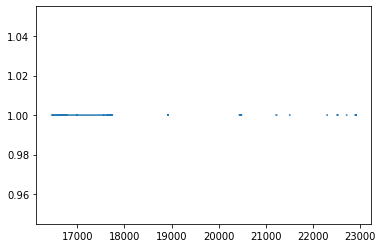

In [9]:
bioscen_species['dispersal1'].plot()

In [ ]:
import pandas as pd

# Set the option to display all columns (None means no limit)
pd.set_option('display.max_columns', None)

# Similarly, to display all rows
pd.set_option('display.max_rows', None)

# Now, when you display your DataFrame, it should show all rows and columns
display(bioscen_species)
